In [1]:
# most common used packages for DSP, have a look into other scipy submodules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal


def my_xcorr2(x, y, scaleopt='none'):
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

# Auto Correlation Function of LTI System's Output

## Task

An LTI system with the DTFT transfer function

\begin{equation}
H(\mathrm{e}^{\mathrm{j}\Omega})=\begin{cases}
	1, & |\Omega|<\Omega_c\\
	0, & \Omega_c\leq|\Omega|\leq\pi
\end{cases}
\end{equation}

for $\Omega_c > 0$ is excited by white noise $x[k]$ that exhibits the input (auto)-PSD $\Phi_{xx}(\mathrm{e}^{\mathrm{j}\Omega}) = \Phi_0$.
We assume that $x[k]$ is drawn from a stationary, ergodic random process.

- Make a sketch of the amplitude response of the transfer function and characterize the system characteristics.
- Calculate the ACF, the linear mean and the variance of the output signal $y[k]$.

## Solution

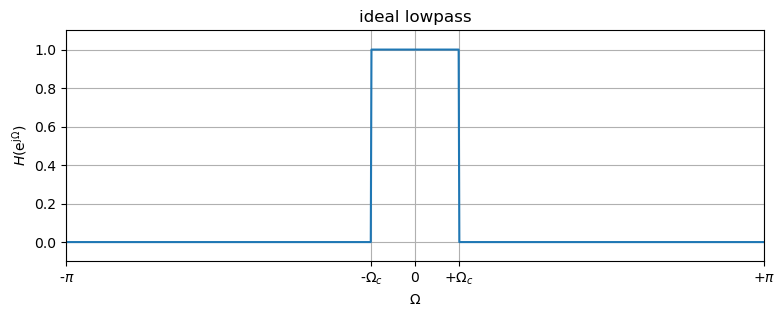

In [2]:
Omegac = np.pi/8  # arbitrary choice, must be <pi
N = 2**10
Omega = np.arange(N) * 2*np.pi/N - np.pi  # [-pi...pi)
H = np.ones(N)
H[Omegac < np.abs(Omega)] = 0
plt.figure(figsize=(9, 3))
plt.plot(Omega, H)
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$H(\mathrm{e}^{\mathrm{j}\Omega})$')
plt.title('ideal lowpass')
plt.xticks([-np.pi, -Omegac, 0, +Omegac, +np.pi],
           [r'-$\pi$', r'-$\Omega_c$', '0', r'+$\Omega_c$', r'+$\pi$'])
plt.xlim(-np.pi, +np.pi)
plt.ylim(-0.1, 1.1)
plt.grid(True)

# Transfer Function of LTI System, Output PSD

## Task

Calculate the PSD $\Phi_{yy}(\mathrm{e}^{\mathrm{j}\Omega})$ of the output signal $y[k]=x[k]\ast h[k]$. Make a sketch of the PSD $\Phi_{yy}(\Omega)$ for $0\leq\Omega<2\pi$.

- $x[k]$ is a stationary random input signal for which the (ideal) auto-correlation function is given as

\begin{equation}
\varphi_{xx}[\kappa]=\sigma_x^2\cdot\delta[\kappa]
\end{equation}

- the impulse response describing the LTI system is given as

\begin{equation}
h[k]=\left(\frac{3}{4}\right)^k\cdot\epsilon[k]
\end{equation}

In signals & systems we learned how to discuss the system characteristics in terms of impulse/step response, frequency response, pole/zero plot, bode plot.
We will need some of this stuff here again.

## Solution



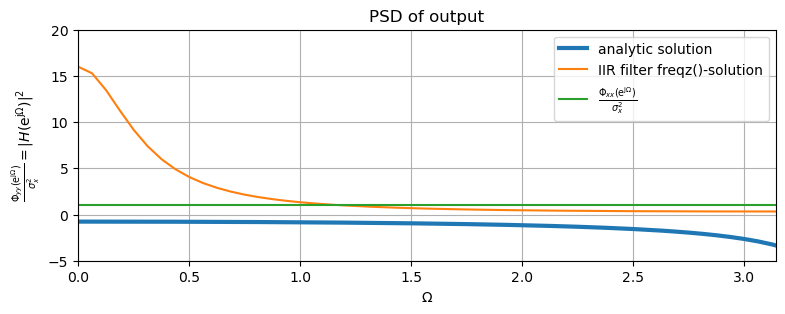

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

Omega_c = np.pi/8  
N = 2**8
Omega = np.arange(N) * 2*np.pi/N
H2 = 2 / (Omega_c - 3*np.cos(Omega))  
Omega, H_IIR = signal.freqz(b=(1), a=(1, -3/4), worN=Omega/Omega_c) 

plt.figure(figsize=(9, 3))
plt.plot(Omega, H2, lw=3, label='analytic solution')
plt.plot(Omega, np.abs(H_IIR)**2, label='IIR filter freqz()-solution')
plt.plot(Omega, Omega*0+1,
         label=r'$\frac{\Phi_{xx}(\mathrm{e}^{\mathrm{j}\Omega})}{\sigma_x^2}$')
plt.xlabel(r'$\Omega$')
plt.ylabel(
    r'$\frac{\Phi_{yy}(\mathrm{e}^{\mathrm{j}\Omega})}{\sigma_x^2} = |H(\mathrm{e}^{\mathrm{j}\Omega})|^2$')
plt.title('PSD of output')
plt.xlim(0, np.pi)
plt.ylim(-5, 20)
plt.legend()
plt.grid(True)

plt.show()


# Exercise 6: Impulse Response Estimation with Random Signal in Time Domain

## Task

In this programming task we want to elaborate how to identify the impulse response of an LTI system with random signal in the time domain.
If white noise is used as input signal, the task becomes very convenient in terms of required signal processing steps. Thus, we

- generate white noise signal $x[k]$ drawn from gaussian PDF
- create finite impulse response $h[k]$ of a simple LTI system, i.e. a lowpass (in practice this would be unknown)
- apply convolution $y[k] = x[k] \ast h[k]$
- estimate the impulse response $\hat{h}[k]$ based on the concept of correlation functions.

## Solution

### Generate White Noise 

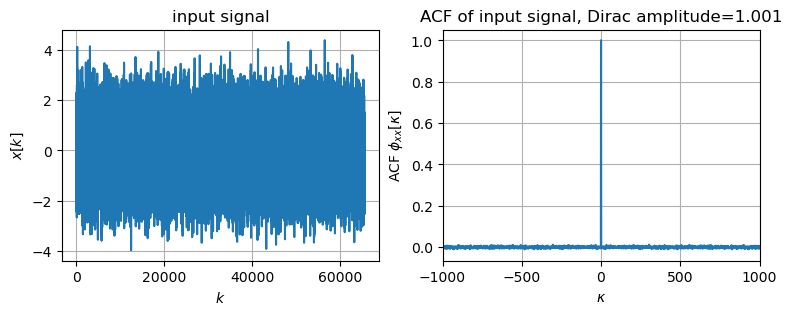

In [4]:
np.random.seed(2) 
Nx = 2**16
k = np.arange(Nx)
x = np.random.randn(Nx)
kappa, phixx = my_xcorr2(x, x, 'biased')  
idx = np.where(kappa == 0)[0][0]

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(k, x)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.title('input signal')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(kappa, phixx)
plt.xlim(-1000, +1000)
plt.xlabel('$\kappa$')
plt.ylabel('ACF $\phi_{xx}[\kappa]$')
plt.title('ACF of input signal, Dirac amplitude=%4.3f' % phixx[idx])
plt.grid(True)

plt.show()


### Create a Finite Impulse Response LTI System


h[0]=0.000, DC=-62.848 dB


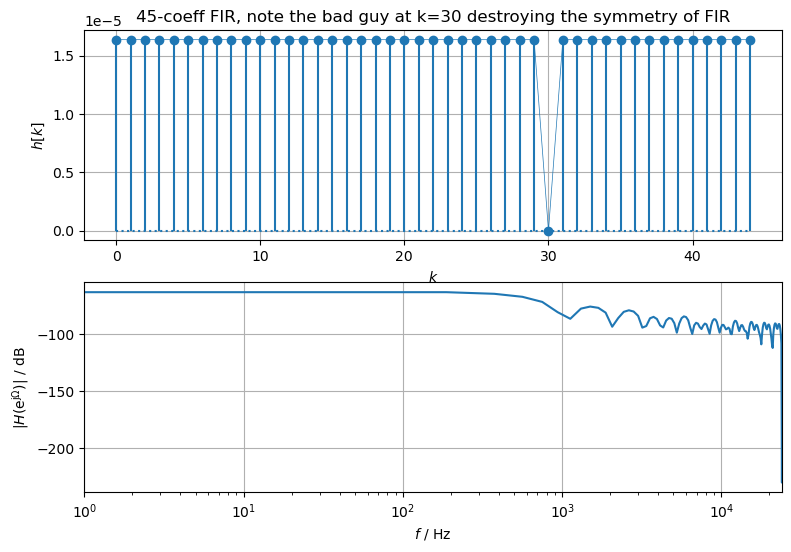

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

fs = 48000  # 
fc = np.pi/8  
number_fir_coeff = 45  # FIR taps
h = signal.firls(numtaps=number_fir_coeff,
                 bands=(0, fc, fc*2, fs//2),  
                 desired=(1, 1, 0, 0),
                 fs=fs)
Nh = h.size
k = np.arange(Nh)
idx = 30
h[idx] = 0  

print('h[0]={0:4.3f}, DC={1:4.3f} dB'.format(h[0], 20*np.log10(np.sum(h))))

N = 2**8
Omega = np.arange(0, N) * 2*np.pi/N
_, H = signal.freqz(b=h, a=1, worN=Omega)

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.stem(k, h, basefmt='C0:')
plt.plot(k, h, 'C0-', lw=0.5)
plt.xlabel(r'$k$')
plt.ylabel(r'$h[k]$')
plt.title(str(Nh)+'-coeff FIR, note the bad guy at k=%d destroying the symmetry of FIR' % idx)
plt.grid(True)
plt.subplot(2, 1, 2)
plt.semilogx(Omega / (2*np.pi) * fs, 20*np.log10(np.abs(H)))
plt.xlabel(r'$f$ / Hz')
plt.ylabel(r'$|H(\mathrm{e}^{\mathrm{j}\Omega})|$ / dB')
plt.xlim(1, fs//2)
#plt.ylim(-40, 10)
plt.grid(True)

plt.show()
